# CNN Transfer Learning with ResNet50

This notebook demonstrates how to use transfer learning with ResNet50 for image classification on the CIFAR-10 dataset. The approach leverages pre-trained weights from ImageNet and adds a custom classification head for the specific task.

## 1. Setup and Imports

In [30]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.datasets import cifar10
import os
import sys

# Add the utils directory to the path
sys.path.append('../utils')
from data_utils import load_cifar10_data, preprocess_data, create_data_augmentation, visualize_samples
from model_utils import create_resnet50_model, create_callbacks, train_model, evaluate_model, plot_training_history, predict_and_visualize, unfreeze_layers
from visualization import plot_confusion_matrix, visualize_feature_maps, visualize_model_architecture, visualize_augmented_images, visualize_class_activation_maps

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

## 2. Load and Preprocess Data

We'll load the CIFAR-10 dataset and preprocess it for our model. This includes resizing the images to 224x224 (required for ResNet50), normalizing pixel values, and converting labels to one-hot encoding.

In [33]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Load CIFAR-10 dataset with a smaller subset for faster training
# Use (5000, 1000) for a smaller subset or None for the full dataset
(x_train, y_train), (x_test, y_test) = load_cifar10_data(subset_size=(5000, 1000))

Loading CIFAR-10 dataset...
Successfully loaded CIFAR-10 dataset
Training data shape: (5000, 32, 32, 3)
Training labels shape: (5000, 1)
Test data shape: (1000, 32, 32, 3)
Test labels shape: (1000, 1)


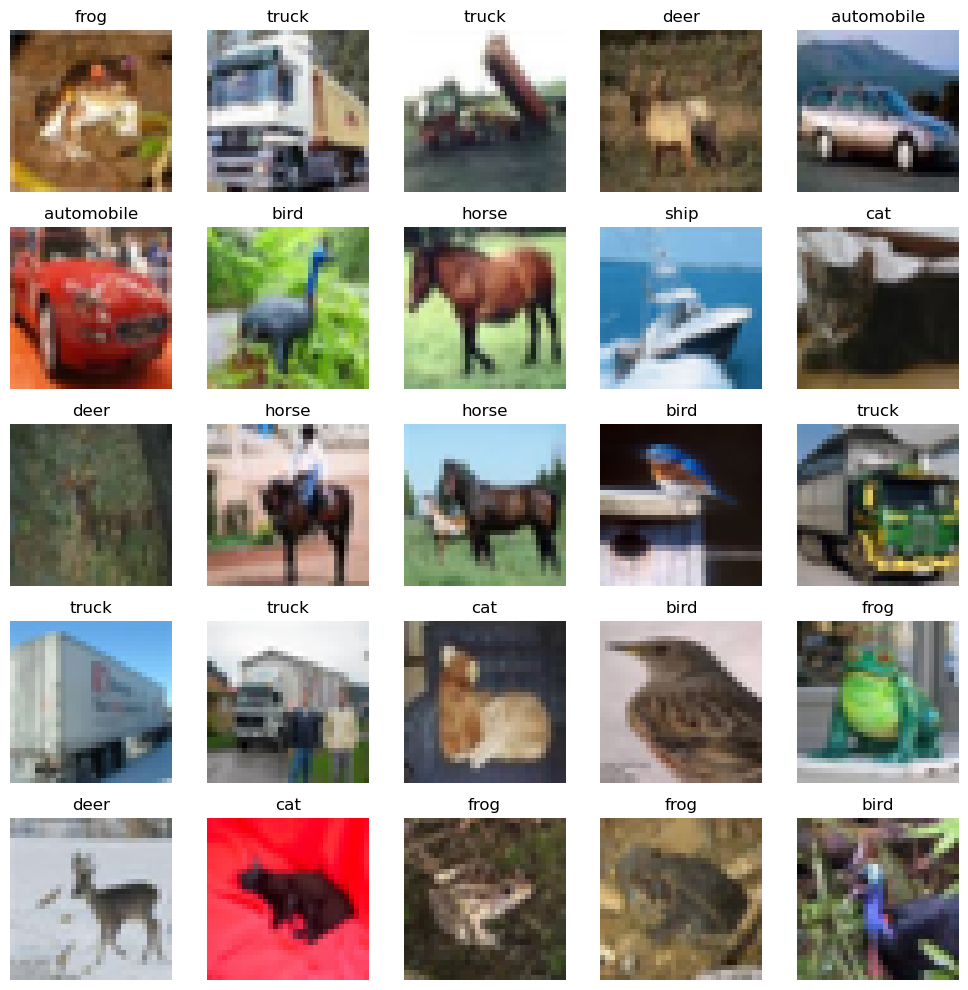

In [35]:
# Visualize some sample images from the dataset
visualize_samples(x_train, y_train, class_names, num_samples=25)

In [37]:
# Preprocess the data (resize to 224x224 for ResNet50, normalize, and convert labels to one-hot)
(x_train, y_train), (x_test, y_test) = preprocess_data(
    x_train, y_train, x_test, y_test, 
    resize_dim=(224, 224), 
    one_hot=True
)

Resizing images to (224, 224)...


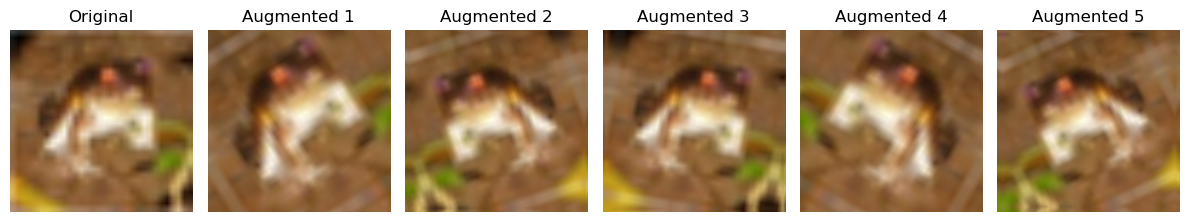

In [38]:
# Create data augmentation pipeline
data_augmentation = create_data_augmentation()

# Visualize augmented images
visualize_augmented_images(data_augmentation, x_train[0:1], num_augmentations=5)

## 3. Create and Compile the Model

We'll use transfer learning with ResNet50 pre-trained on ImageNet. We'll freeze the base layers and add our own classification head.

In [40]:
# Create the model
model = create_resnet50_model(
    input_shape=(224, 224, 3),
    num_classes=10,
    freeze_layers=True
)

# Visualize the model architecture
visualize_model_architecture(model)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,850 (91.99 MB)

 Trainable params: 527,626 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Model visualization not available. TensorFlow version may not support it.


<Figure size 1200x1200 with 0 Axes>

In [41]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_light_cnn(input_shape=(32, 32, 3), num_classes=10):
    odel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_light_cnn()
model.summary()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,850 (91.99 MB)

 Trainable params: 527,626 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [42]:

# Train the lightweight model
import tensorflow as tf

# Resize training and testing data to 32x32
x_train_resized = tf.image.resize(x_train, (32, 32))
x_test_resized = tf.image.resize(x_test, (32, 32))

# Train using resized data
history = model.fit(
    x_train_resized, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.1,
    verbose=2
)

Epoch 1/5


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 32, 32, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 32, 32, 3), dtype=float32)
  • training=True
  • mask=None

## 4. Train the Model

We'll train the model with the frozen base layers first, then optionally fine-tune by unfreezing some layers.

In [ ]:
# Create callbacks for training
callbacks = create_callbacks(
    checkpoint_path='../models/saved_models/resnet50_cifar10.h5',
    patience=5
)

# Train the model
model, history = train_model(
    model=model,
    x_train=x_train,
    y_train=y_train,
    batch_size=32,
    epochs=15,  # Start with fewer epochs for the initial training
    validation_split=0.2,
    callbacks=callbacks
)

# Plot training history
plot_training_history(history)

## 5. Fine-tune the Model (Optional)

After initial training with frozen base layers, we can unfreeze some layers and continue training with a lower learning rate.

In [ ]:
# Unfreeze the last few layers of the base model for fine-tuning
model = unfreeze_layers(model, num_layers_to_unfreeze=10)

# Continue training with a lower learning rate
model, fine_tune_history = train_model(
    model=model,
    x_train=x_train,
    y_train=y_train,
    batch_size=32,
    epochs=10,  # Additional epochs for fine-tuning
    validation_split=0.2,
    callbacks=callbacks
)

# Plot fine-tuning history
plot_training_history(fine_tune_history)

## 6. Evaluate the Model

Now we'll evaluate the model on the test set and visualize the results.

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = evaluate_model(model, x_test, y_test)

In [ ]:
# Make predictions and visualize results
predict_and_visualize(model, x_test, y_test, class_names, num_samples=10)

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(model, x_test, y_test, class_names)

## 7. Visualize Model Interpretability

Let's visualize feature maps and class activation maps to understand what the model is looking at.

In [ ]:
# Visualize feature maps for a sample image
sample_image = x_test[0]
visualize_feature_maps(model, sample_image)

In [ ]:
# Visualize class activation maps
# Get the predicted class for the sample image
pred = model.predict(np.expand_dims(sample_image, axis=0))
pred_class = np.argmax(pred[0])

# Visualize class activation map for the predicted class
visualize_class_activation_maps(model, sample_image, pred_class)

## 8. Save the Model

Finally, let's save the trained model for future use.

In [ ]:
# Save the model
model_save_path = '../models/saved_models/resnet50_cifar10_final.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

## 9. Conclusion

In this notebook, we've demonstrated how to use transfer learning with ResNet50 for image classification on the CIFAR-10 dataset. We've shown the complete pipeline from data loading and preprocessing to model training, evaluation, and visualization.

Key takeaways:
- Transfer learning allows us to leverage pre-trained models for new tasks
- Data augmentation helps prevent overfitting and improves generalization
- Fine-tuning can further improve performance after initial training
- Visualization techniques help understand what the model is learning